# [Exploration 11] 뉴스 요약봇 만들기
## 프로젝트 설명 
---
DCGAN을 이용해 CIFAR-10데이터를 생선하는 프로젝트


## 프로젝트 정리     
---        
1. 데이터셋 구성하기 
2. 생성자 모델 구현하기

3. 판별자 모델 구현하기 

4. 손실함수와 최적화 함수 구현하기

5. 훈련과정 상세 기능 구현하기
6. 학습 과정 진행하기 
7. GAN 훈련 과정 개선하기


## 프로젝트 목표
---
- lstm, seq2seq, attention 메커니즘을 이해한다.
- 데이터 전처리 과정을 이해한다.
- 추상적 요약(Abstractive Summarization)과 추출적 요약(Extractive Summarization)의 차이점을 이해한다. 


## 01. 데이터셋 구성하기 
- tf.keras 안의 dataset에 포함되어있는 cifar-10데이터셋을 다운로드 받습니다.

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


In [3]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()
train_x.shape

(50000, 32, 32, 3)

- classification 문제를 해결하는 것이 아니기 때문에 정답(label)이 있는 y test는 사용하지 않습니다.(_ 언더바 사용)
- CIFAR-10
    - 32 x 32 x 3 (컬러 이미지)
    - 각 픽셀 수의 스케일을 확인하고, 너무 크면 정규화 작업을 진행합니다.

In [4]:
print(train_x.max())
print(train_x.min())

255
0


- 0 ~ 255 사이의 값
- -1 ~ 1 사이의 값으로 정규화합니다. 

In [5]:
train_x = (train_x - 127.5) / 127.5
print(train_x.max())
print(train_x.min())

1.0
-1.0


- 첫 번째 데이터를 이미지로 출력해서 확인합니다.

In [13]:
train_x.dtype

dtype('float64')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


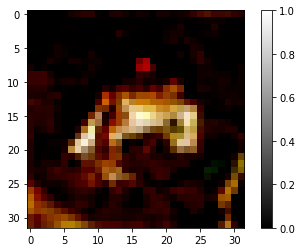

In [31]:
plt.imshow(train_x[0].reshape(32, 32, 3), cmap='gray')
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

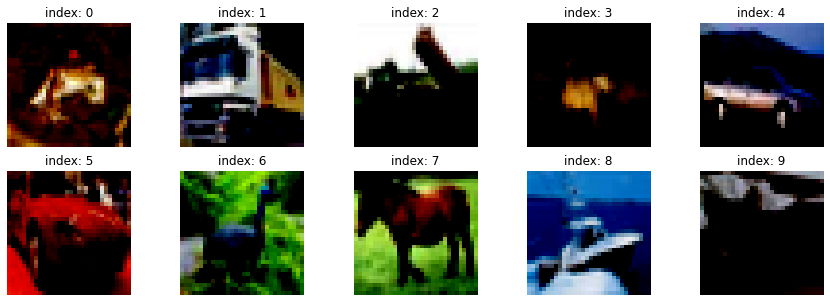

In [30]:
plt.figure(figsize=(15, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(32, 32, 3), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

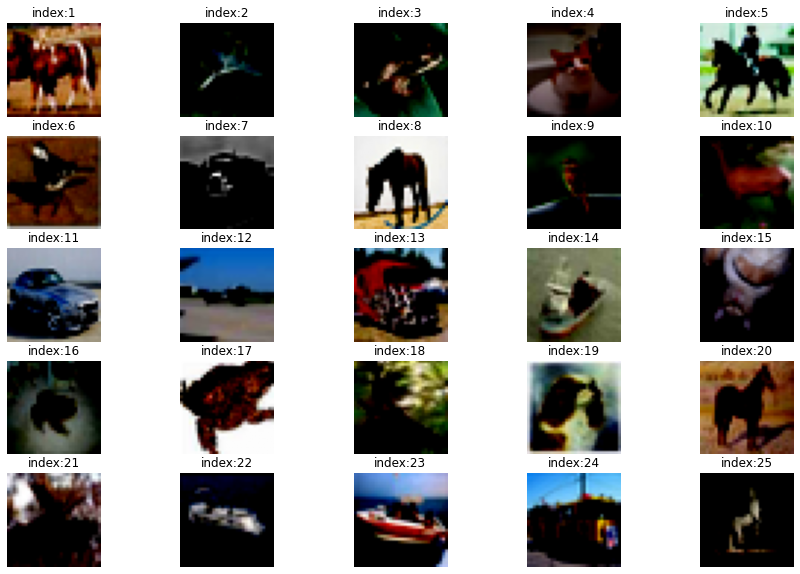

In [37]:
plt.figure(figsize=(15, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index].reshape(32, 32, 3))
    plt.title(f'index:{i+1}')
    plt.axis('off')
plt.show()

- BUFFER_SIZE 만큼의 양(50000)의 데이터를 섞어서 모델에 넣습니다. (전체 데이터셋과 크기를 똑같이 하는 것이 좋습니다.)
- BATCH_SIZE 만큼의 양을 모델이 한번에 학습합니다. (미니배치 학습)

In [38]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [39]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 02. 생성자(Generator model) 구현
- input : (batch_size, 100) 사이즈의 노이즈 벡터

In [52]:
def make_generator_model():
    # start
    model = tf.keras.Sequential()
    
    # first : dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # second : reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # third : conv2d transpose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # fourth : conv2d transpose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # fifth : conv2d transpose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

- 모델을 구성하는 함수를 만들었는데, 이 함수를 사용하는 방법을 순차적으로 정리해보겠습니다.   
    1) make_generator_model() 을 generator라는 instance에 할당한다.   
    2) generator는 make_generator_model() 함수가 반환하는 model을 가져온다.

In [53]:
generator = make_generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_5 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)        

In [54]:
noise = tf.random.normal([1, 100])

3) model에 input인 noise를 넣어준다. 

In [55]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

4) 생성한 이미지를 출력해서 본다.

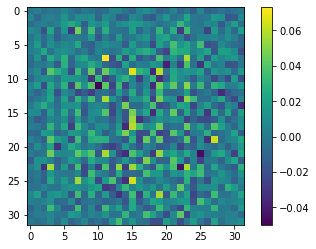

In [65]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

- -1과 1 사이의 값에서 생성되었다. (colorbar scale 참고)


## 03. 판별자 (discriminator model) 구현

In [68]:
def make_discriminator_model():
    
    # start
    model = tf.keras.Sequential()
    
    # first : conv2d layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # second : conv2d layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # third : flatten layer
    model.add(layers.Flatten())
    
    # fifth : Dense layer
    model.add(layers.Dense(1))
    
    return model

In [69]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

- generator로 생성했던 이미지를 판별자로 구분해보겠습니다.

In [70]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00204465]], dtype=float32)>

## 04. 손실함수와 최적화함수 구현
- GAN은 손실함수로 교차 엔트로피(cross entropy)를 사용합니다.
    - 가짜, 진짜를 나타내야하기 때문에 이진 교차 엔트로피(binary cross entropy)사용
- real image = 1, fake image = 0 라벨을 설정합니다.
    - 생성자는 1에 가까운 값을, 판별자는 0에 가까운 값을 목표로 합니다.
    - real image : tf.ones_like()
    - fake image : tf.zeros_like()

- BinaryCrossentropy : 인풋이 0-1 사이에 분포하는 확률값이라고 가정한다.
- from_logits=True : 입력 값을 내부 sigmoid함수로 0-1 사이로 정규화한다.

In [71]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

- cross_entropy를 이용해 생성자가 생성한 fake_output, 기존 real image를 판별자가 판별한 값인 real_output으로 loss를 계산합니다.
- generator_loss : fake output -> 1 (tf.ones_like()사용)
- discriminator_loss :    
    fake output -> 0 (tf.zeros_like()사용)   
    real output -> 1 (tf.ones_like()사용)

In [73]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [72]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

- discriminator accuracy
    - 판별자가 얼마나 정확히 판별하는지 accuracy 계산(real, fake)
- 함수 설명
    - real_output의 원소가 tf.constatnt(\[0.5\]) 이상이면 true, 아니면 false로 판별
    - true = 1.0, false = 0.0으로 변환
    - 해당을 평균내서 배치의 정확도를 계산 

In [74]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

- 최적화 함수 (optimizer) 구현
    - Adam 사용 

In [75]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

- 생성자가 생성한 샘플을 확인하기 위한 노이즈(seed)를 생성합니다.
- 샘플은 한 번에 16장씩 확인합니다.

In [76]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 05. 훈련과정 구현
- @tf.function 데코레이터를 사용한다.

In [90]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # (1) 이미지 생성 from noise
        generated_images = generator(noise, training=True)
        # (2) 실제 이미지와 (1)에서 생성된 이미지를 판별 
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        # (3) 생성한 이미지를 (2)에서 검사받고 그에 대한 loss 계산
        gen_loss = generator_loss(fake_output)
        # (4) 실제 이미지와 생성 이미지에 대해 판별 loss 게산
        disc_loss = discriminator_loss(real_output, fake_output)
        
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

- 위에서 만든 train_step()을 이용해서 일정 간격으로 학습을 합니다.
- 일정 간격 학습할 때마다 학습 현황을 볼 수 있는 샘플 생성 함수를 구현합니다.

In [96]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4, 4))  # 16장 샘플을 보기로 했다. 
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i,:,:,0]) # plt는 2차원만 볼 수 있다. 
        plt.axis('off')
    
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(os.getenv('HOME'), epoch, it))
    plt.show()

- 학습 그래프그리는 함수를 구현합니다.

In [100]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6 # matlab 차트의 크기 설정

def draw_train_history(history, epoch):
    # loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')
    
    # accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])    
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    # 그래프를 이미지로 저장 
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'.format(os.getenv('HOME'),epoch))
    plt.show()

- 모델 저장을 위한 checkpoint를 구현합니다.

In [82]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

## 06. 학습하기
- 위에서 구현한 여러 함수를 합칩니다.

In [83]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)            
            history['real_accuracy'].append(real_accuracy)            
            history['fake_accuracy'].append(fake_accuracy)  
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))
                
        if (epoch+1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for trining : {}sec'.format(int(time.time()-start)))
        
        draw_train_history(history, epoch)

In [104]:
save_every = 10
EPOCHS = 100

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

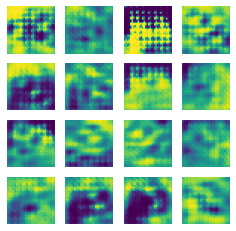

Epoch 3 | iter 51
Time for epoch 3 : 3 sec


In [ ]:
train(train_dataset, EPOCHS, save_every)

# 루브릭 평가
---
1. **GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.**   
    - 오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.

2. **생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.**
    - gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.
     
3. **추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.** 
    - 제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.
    
    
# 회고
---
## 어려웠던 점 
- 평가
    - 영어로 된 기사의 요약을 직접 읽어서 평가하는 방법이 어려웠다.
    
## 알게된 점 
- attention
    - 노드의 가중치를 적용하는 attention을 직접 구성하고 동작시켜보았다.
- np.random.shuffle
    - numpy array의 순서를 indicies로 섞는 코드를 뜯어보면서 익힐 수 있었다.\
- tokenizer의 데이터타입
    - tokenizer의 여러 속성의 데이터 타입을 직접 확인하였다. 
    
## 더 공부할 점
- 요약 평가 지표 적용
    - 직접 읽어서 확인하는 것이 아닌 정량적인 평가 지표가 있다고 한다. 이를 직접 적용시켜보고 싶다.

## 다짐
- 개념에 대해 파악하고 궁금한 점을 찾아보느라, 시간이 늦어져 학습을 여러 번 해보지 못한 점이 아쉽다. 더 효율적으로 프로젝트를 진행하는 방법을 익혀야겠다. 코드에 대해 공식 다큐먼트로도 이해가 가지 않을 때에는 작은 데이터셋을 직접 만들어 실험해보면서 문법을 공부할 수 있었다.